# Quantum classifier

In this code we are going to implement a quantum classifier. In this case, we are going to have a single-qubit and a two-qubit classifier. 

### Single-qubit classifier: 
Using only one qubit, we can design a universal classifier, i.e., a model that is able to classify with any criteria. We are going to approach this with a quantum circuit with one qubit, using parametrized gates. This gates will be general rotations of a qubit and we are going to use the angles of these rotations to codify certain information that we want. Specifically, we will use these angles to introduce the parameters to optimize. On the other hand, we also need to introduce the data in the circuit. Because of the no cloning theorem, we will have to manually introduce the data in each step of the processement, also in the angles of the rotation of the parametrized gates. This procedure is known as data re-uploading.


This quantum algorithm pertains to the class of variational algorithms, in which we compute a certain quantity with our quantum circuit but then we classicaly build a cost function and we optimize it also with classical methods. For this type of methods we need a certain ansatz, this is, a general structure of the circuit that will depend on certain parameters. In our case we have a quantum circuit with several layers (the number of layers will depend on the accuracy that we want to obtain for our classification). Each layer is formed by 2 quantum one-qubit rotation gates, with 3-angles that will fully characterize the rotation ($U(\theta, \psi, \delta)$). The first gate will have codifed the data-points ($U(\vec{x})$) and the second gate will codify the parameters that we want to optimize ($U(\vec{\theta})$). 

How we build our cost function? First, we assign to each data-point a category. Each category will have associated as a label a quantum state on the Bloch sphere. When we run our quantum circuit, we will obtain a state that will depend on the data used and on the parameters: $|\psi_c(\vec{x}, \vec{\theta})\rangle$. Then, we will compute the fidelity between the output state and the state associated to the category of the given data-point $\vec{x}$. This will determine how far or how close we are from our target state. Then, our cost function for a given training set will be given by: 


$C(\vec{\theta},\vec{x}) = \sum_i | \langle \psi_t| \psi_c(\vec{x}, \vec{\theta})\rangle |^2 $


With this cost function we can use classical subroutines to find the parameters that will minimize its value. 



### Two-qubit classifier: 

In this code it is also implemented a 2-qubit version of the quantum classifier. In this case we have to introduce entanglement into our ansatz. 


How we build the cost function if we use the information of only one qubit in the two-qubit ansatz? Since we are performing all the operations on the two-qubit circuit if we look only at one qubit we will have a density matrix, since in general the two qubits will be entangled. Focusing on the reduced density matrix of the subsystem of one of the qubits, $\rho_i(\vec{x}, \vec{\theta})$, we can compute the fidelity like $\langle \psi_t |\rho_i |\psi_t\rangle $, where $|\psi_t\rangle$ is the quantum state associated to the correct category of the data-point. Why we use this method, if we can use as label the states of the 2-qubit system? We use only this approach to compare the performance of the single-qubit classifier with the two-qubit classifier. In this way we do not have the advantatge of having $4$ orthogonal states instead of $2$ in the single-qubit classifier and we can focuss on other aspects such as how the entanglement improves the method. 

In [3]:
import numpy as np 
# Qibo modules
from qibo.models import Circuit
from qibo import gates, K

#optimization method
from scipy.optimize import minimize

#Ploting results
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize


#For computing the gradients 
from scipy.optimize import rosen, rosen_der
from scipy.optimize.optimize import approx_fprime

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[Qibo 0.1.7|INFO|2022-06-24 05:39:57]: Using qibojit (numba) backend on /CPU:0


In [9]:
seed = 7


class classifier:
    def __init__(self, problem_name, qubits, layers, meas = None, num_samples=300, seed=7):

        """"Class that includes all the necessary for the quantum-classifier
        
        
        Args: 
            - problem_name (str): Classification problem we aim to solve. The options are
                                ['circle', '3_circles'].
            - qubits (int): Number of qubits that the classifier will have. Options: 1 or 2.
            - layers(int): Number of layers that our circuit ansatz will have. 
            - meas (str or None): This will only be required if we are working with the 2-qubit
                                  classifier, and will indicate if we want to build the cost funciton 
                                  of the problem based only on the measure of one of the two qubits.
                                  (More details of the cost function in the explanation above )
                                  Options: 0, if we want to measure on the first qubit or 1, if we 
                                  want to measure the second one, None if we want to measure both,
            - num_samples (int): Number of data-points for classification used on the training and in the testing set.
            - seed (int): Random seed

        Returns: 
            - Training set and test set (array: (x,y)).
                    - x (array): data-points of the form (x_1, x_2)
                    - y (int): Classification label. (Example: 0 for inside a given circle and 1 for outside the circle)
            - Params (array): initial random parameters for the circuit. 
            - Targets (list of arrays): quantum states associated to the targets states. The index of the list 
                                        is the label y. (Example: the label 0 corresponds to the category 
                                        'inside the circle', and therfore targets[0] = np.array([1,0], type= 'complex'),
                                        will contain the quantum state associated to this category).
            """
            
        np.random.seed(seed)
        self.problem_name = problem_name
        self.qubits = qubits
        self.layers = layers 
        self.num_samples = num_samples
        self.training_set = self.create_dataset()
        self.testing_set = self.create_dataset()
        self.params = np.random.uniform(size=(self.layers,self.qubits, 3))

        #Only different from 'None' when we have more than one qubit and we want to measure only one of them.
        self.meas = meas
        self.targets = self.target_states()
        #if meas = None-> computational basis of the qubits.
       

       
    def create_dataset(self):
        """ Function that creates the dataset (x,y) for the classification problems.

        Returns: 
        - x (array): data-points generated randomly 
        - labels (array): labels for the classification. We will have as many possible labels as categories.
        """
        name = self.problem_name
        samples = self.num_samples
        x = 1-2*np.random.rand(samples, 2)
        x = np.hstack((x, np.zeros((x.shape[0], 1))))
        labels = np.zeros(samples, dtype=np.int32)
        if name == 'circle': 
            
        #Returns the indices where the condition is fulfilled  
            ids = np.where(np.linalg.norm(x, axis=1) > np.sqrt(2 / np.pi))
            labels[ids] = 1
            
        elif name == '3_circles':
            ids_1 = np.where(np.linalg.norm(x-([0.5,0]+[0]*1), axis = 1)<0.5)
            labels[ids_1] = 1
            
            ids_2 = np.where(np.linalg.norm(x-([-0.7,-0.6]+[0]*1), axis = 1)<0.5)
            labels[ids_2] = 2 
            
            ids_3 = np.where(np.linalg.norm(x-([-0.7,0.8]+[0]*1), axis = 1)<0.7)
            labels[ids_3] = 3   
            
        else: 
            print('problem not defined')
        return x,labels



    def target_states(self):
        """Creates the quantum states for computing the fidelity in the cost function. Each 
            state is associated to a category for the classification. 

            Returns:
                - targets (list of arrays): list that contain all the quantum states needed for the classification. 

            """
        if self.problem_name == 'circle':
            if self.qubits==1 or self.meas is not None:
                targets = [ np.array([1, 0], dtype='complex'),
                            np.array([0, 1], dtype='complex')]
            elif self.qubits ==2 and self.meas == None:
                targets = [ np.array([1, 0, 0, 0], dtype='complex'),
                            np.array([0, 1, 0, 0], dtype='complex')]

        elif self.problem_name == '3_circles' or self.problem_namename == '_3_circles':
            if self.qubits == 1 or self.meas is not None: 
                targets = [np.array([1, 0], dtype=complex),
                           np.array([1 / np.sqrt(3), np.sqrt(2 / 3)], dtype='complex'),
                           np.array([1 / np.sqrt(3), np.exp(1j * 2 * np.pi / 3)
                                    * np.sqrt(2 / 3)], dtype=complex),
                        np.array([1 / np.sqrt(3), np.exp(-1j * 2 * np.pi / 3) * np.sqrt(2 / 3)], dtype='complex')]
            elif self.qubits == 2 and self.meas == None:
                targets = [ np.array([1, 0, 0, 0], dtype='complex'),
                            np.array([0, 1, 0, 0], dtype='complex'),
                            np.array([0, 0, 1, 0], dtype='complex'),
                            np.array([0, 0, 0, 1], dtype='complex')]
        return targets

    def fidelity(self, st1, st2):
        """This function computes the fidelity between two quantum states. 
        Args: 
        - st1, st2 (arrays): quantum states
            *if self.meas is None-> st2 is a density matrix
        Returns: 
        - Fidelity between quantum states. """
        if self.meas is  None: 
            fid = np.abs(np.dot(np.conjugate(st1.T), st2))**2
        else: 
            fid = np.real(np.dot(np.conjugate(st1.T), np.dot(st2,st1 )))

        return fid

    def circuit_ansatz(self,x): 

        """We create the circuit ansatz for the problem. 
            -> For the single-qubit classifier: 

                -[U3(X)]-[U3(P_1)]---···---[U3(X)]-[U3(P_N)]-, 

                where N is the number of layers and U3 is the general rotation 
                for a single qubit. P_I indicates the set of 3 parameters in the layer I. 
            -> For the two-qubit classifier:

                -[U3(X)]-[U3(P_11)]-º------------------···-[U3(X)]-[U3(P_N1)]-º--------------------
                                    |                                         |
                -------------------(+)-[U3(X)]-[U3(P_12)]···-----------------(+)--[U3(X)]-[U3(P_N2)]-, 

                where in P_IJ, I indicates the number of layer and J the qubit. Also we have introduced 
                CNOTs. 
            
        Args:
        - x(array): single data-point 

        Returns: 
        - circuit qibo object."""

        #If we want to measure on only one qubit, on the two-qubit ansatz, we will switch density matrix = True
        #Then the output of the circuit will be a density matrix and we will be able to compute the reduced density 
        # matrix of the qubit  
        C = Circuit(self.qubits, density_matrix = (self.meas !=  None))


        #We run the number of layers
        for p in self.params: 
            #In each layer, we run the number of qubits.
            for idx, p_i in enumerate(p): 
                #We apply the U3 rotation with the given data-points and parameters.
                C.add(gates.U3(idx, theta= x[0], phi= x[1], lam= x[2], trainable = False))
                C.add(gates.U3(idx, theta= p_i[0], phi=  p_i[1],  lam  = p_i[2],trainable = True))

                #We apply a Cnot if we have the two-qubit ansatz
                if idx == 0 and self.qubits >1: 
                    C.add(gates.CNOT(idx,idx+1))

        #We trace out the qubit that we do not want
        if self.meas is not None: 
             C.add(gates.PartialTrace(np.abs(1-self.meas)))
        return C


    def cost_function(self, params = None): 
        """This function computes the normalized sum of the fidelities between the label state for the classification and the state obtained
        via passing the data through the circuit (with the given params). 

        Args: 
            -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function. 
        """
        

        #If the arg of the function is given, we upload the value of the params of the class
        if params is not None: 
            #We need a reshape because the output of the minimization method is a list. 
            self.params = params.reshape(self.layers, self.qubits, 3)

    
        cf = 0 
        targets = self.target_states()

        #For every data point, we compute the fidelity with the given params.
        for x, y in zip(self.training_set[0],self.training_set[1]):

            C = self.circuit_ansatz(x)
            state =  C.execute()

            
            if self.qubits == 1: 
                state_one_qubit = np.array([state[0], state[1]])
                fid = self.fidelity(targets[y], state_one_qubit)


            elif self.qubits ==2: 
                if self.meas is None:
                    state_two_qubits = np.array([state[0], state[1], state[2], state[3]])
                    fid = self.fidelity(targets[y], state_two_qubits)

                #If we choose to build the cost function with the information of only one of the qubits, then we will need to 
                #construct the reduced density matrix. We re-arrange the output that qibo gives.
                elif self.meas == 0: 
                    rho_0 = np.zeros((2,2), dtype='complex')
                    rho_0[0][0] = state[0].reshape(2,2)[0][0]
                    rho_0[0][1] = state[0].reshape(2,2)[1][0]
                    rho_0[1][0] = state[2].reshape(2,2)[0][0]
                    rho_0[1][1] = state[2].reshape(2,2)[1][0]
                    fid = self.fidelity(targets[y], rho_0)
                elif self.meas ==1: 
                    rho_1 = np.zeros((2,2), dtype='complex')
                    rho_1[0][0] = state[0].reshape(2,2)[0][0]
                    rho_1[0][1] = state[0].reshape(2,2)[0][1]
                    rho_1[1][0] = state[1].reshape(2,2)[0][0]
                    rho_1[1][1] = state[1].reshape(2,2)[0][1]
                    fid = self.fidelity(targets[y], rho_1)
            #We add to the cost function the contribution of each data-point        
            cf += (1 - fid) ** 2
        cf /= len(self.training_set[1])
        print(cf)
        return cf 



    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"This function minimizes the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization. Also computes 
        the values of the gradients of the parameters.
        
        Args: 
            - Method (str): Method used to minimize the cost function. Options: ['bfgs', 
                'L-BFGS-B', 'Nelder-Mead', ...]
            - Options (dict): Options for the minimization
            - Complie?
        Returns: 
        
            -result (float): value of the cost function after the minimization. 
            -parameters (list): list of the parameters that accomplish the minimization.
            - exact (list): list of the exact values of the gradients of the parameters. 
            - approx (list): list of the approximate values of the gradients of the parameters.
              """


        exact = []
        approx = []
        def callback(x):
           exact.append(rosen_der(x))
           approx.append(approx_fprime(x, rosen, 1E-8))

        m = minimize(lambda p: K.to_numpy(self.cost_function(p)), x0 =self.params,
                    method = method, options=options, callback=callback)

       
        result = m.fun
        parameters = m.x

        return result, parameters, exact, approx



    def eval_test_set_fidelity(self,params_opt):

        """This function returns the labels of the classification states predicted for each data-point. 
        We run our circuit for all the data with the optimized parameters and we compute the fidellity with 
        all the target states. We keep the label of the greater fidelity among all the target states and 
        this label is the predicted one.

        Args: 
            -params_opt: Parameters used in the classifier circuit. 
        Returns: 
            - labels: list with the predicted labels for each data-point."""
        targets = self.targets
        self.params = params_opt
        
        labels = np.zeros(len(self.testing_set[1]))
        for i,x in enumerate(self.training_set[0]):
            fidelities = []
            C = self.circuit_ansatz(x)
            state =  C.execute()
            if self.qubits == 1: 
                state_circuit = np.array([state[0], state[1]])
            elif self.qubits ==2: 
                if self.meas is None: 
                    state_circuit = np.array([state[0], state[1], state[2], state[3]])
                elif self.meas == 0: 
                    state_circuit = np.zeros((2,2), dtype='complex')
                    state_circuit[0][0] = state[0].reshape(2,2)[0][0]
                    state_circuit[0][1] = state[0].reshape(2,2)[1][0]
                    state_circuit[1][0] = state[2].reshape(2,2)[0][0]
                    state_circuit[1][1] = state[2].reshape(2,2)[1][0]
                elif self.meas ==1: 
                    state_circuit = np.zeros((2,2), dtype='complex')
                    state_circuit[0][0] = state[0].reshape(2,2)[0][0]
                    state_circuit[0][1] = state[0].reshape(2,2)[0][1]
                    state_circuit[1][0] = state[1].reshape(2,2)[0][0]
                    state_circuit[1][1] = state[1].reshape(2,2)[0][1]

            for targ in targets:
                fidelities.append(self.fidelity(targ, state_circuit))
            labels[i] = np.argmax(fidelities)
        return labels

    def accuracy_score(y_pred, y_real):

        """Computes the accuracy as the ratio of the number of right predicted labels and the number of total attempts. 
        
            Args: 
                -y_pred (array of ints): array with the predicted labels.
                -y_real (array of ints): array with the real labels.

            Returns: 
                - proportion of right predictions. 
                
                """
        score = y_pred == y_real
        return score.sum() / len(y_real)

    def paint_results(self, params_opt): 
        """This function plots graphically the obtained results of the classification.
            
            Args: 
            - params_opt: parameters that minimize the cost function. 

            Returns:
            - figure with the classification result."""

        
        params_opt = params_opt.reshape(self.layers, self.qubits, 3)
        fig, axs = plt.subplots(ncols=2, figsize=(9, 4))
        #We plot the contourn of the figures.
        for ax in axs:
            if self.problem_name == 'circle': 
                circle = plt.Circle((0, 0), np.sqrt(2 / np.pi),
                        color='black', fill=False, zorder=10)
                ax.add_artist(circle)
            if self.problem_name == '3_circles': 
                circle1 = plt.Circle((0.5,0), 0.5, 
                                    color = 'black', fill = False, zorder = 10)
                ax.add_artist(circle1)
                
                circle2 = plt.Circle((-0.7,-0.6), 0.5, 
                                    color = 'black', fill = False, zorder = 10)
                ax.add_artist(circle2)
                
                circle3 = plt.Circle((-0.7,0.8), 0.7, 
                                    color = 'black', fill = False, zorder = 10)
                ax.add_artist(circle3)

        #We obtain the guessed labels with the optimized parameters      
        guessed_labels = self.eval_test_set_fidelity(params_opt)
        X = self.training_set[0]
        x1, x2 = X[:,0], X[:,1]
        colors_classes = get_cmap('tab10')
        norm_class = Normalize(vmin=0, vmax=10)
        axs[0].scatter(x1, x2, c=guessed_labels, s=2,
                        cmap=colors_classes, norm=norm_class)
        
        colors_rightwrong = get_cmap('RdYlGn')
        norm_rightwrong = Normalize(vmin=-.1, vmax=1.1)

        #We check the guessed labels with the correct ones.
        checks = [int(g == l) for g, l in zip(guessed_labels, self.training_set[1])]
        axs[1].scatter(x1, x2, c=checks, s=2,
                cmap=colors_rightwrong, norm=norm_rightwrong)
        accuracy = 100.00 * np.sum(checks) / len(checks)
        print('The accuracy for this classification is %.2f' %
            (100 * np.sum(checks) / len(checks)), '%')
        res = [accuracy, self.qubits, self.layers, self.layers*self.qubits*2,self.layers*self.qubits*3]
        fig.suptitle('Accuracy: {:.2f} % | Qubits:{:2d} | Layers: {:2d} | Gates: {:2d} | Parameters: {:2d}'.format(*res))
        return accuracy


0.3414645770356576
0.34146457737056873
0.3414645768450939
0.34146457713454337
0.341464577166583
0.3414645766190779
0.34146457678650627
0.3414645772369854
0.3414645772457895
0.34146457675788655
0.341464576794166
0.3414645768529947
0.3414645768123192
0.3414645768246883
0.3414645770356575
0.34146457701170485
0.34146457746568576
0.3414645770356576
0.34146457643838257
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41465D-01    |proj g|=  5.97275D-02


 This problem is unconstrained.


0.25881159123284414
0.25881159082831395
0.2588115911932621
0.25881159133680326
0.25881159127069764
0.2588115912524681
0.25881159116597263
0.2588115911782032
0.25881159145618665
0.2588115908949115
0.25881159099744705
0.2588115908629532
0.2588115911297522
0.25881159110542656
0.25881159123284403
0.25881159118890795
0.2588115914591832
0.2588115912328442
0.2588115910548258

At iterate    1    f=  2.58812D-01    |proj g|=  4.04530D-02
0.21913153756955392
0.21913153775803323
0.2191315374890383
0.21913153752843134
0.21913153746005548
0.21913153731750612
0.21913153757366033
0.2191315369254194
0.21913153786612427
0.21913153740970448
0.21913153794938073
0.21913153741597172
0.21913153771586194
0.21913153771189206
0.21913153756955409
0.21913153782565464
0.21913153728429977
0.219131537569554
0.21913153750758393

At iterate    2    f=  2.19132D-01    |proj g|=  6.44135D-02
0.19023743667246826
0.19023743646587568
0.19023743675655175
0.19023743671053667
0.1902374369587265
0.19023743695199483
0.19023743

93.33333333333333

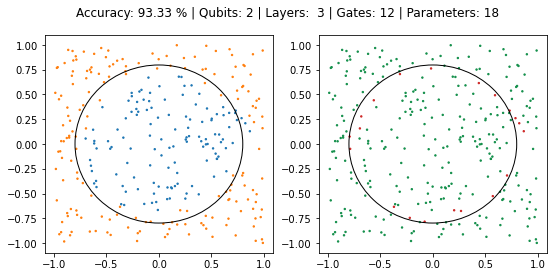

In [20]:
#Prova
prova = classifier('circle', qubits=2,layers= 3, meas = 1)
_,params_prova, _,_ = prova.minimize_funct(method='L-BFGS-B', 
                                         options={'disp': True}, compile= True)
prova.paint_results(params_opt = params_prova)

0.54
0.54
0.54
0.54
0.54
0.54
0.54
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40000D-01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00   5.400D-01
  F =  0.54000000000000004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


The accuracy for this classification is 46.00 %


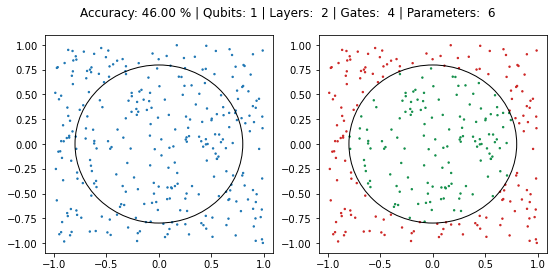

In [16]:
#2 qubits with local cost function. Measure on the second qubit
layer_test = [x for x in range(2,3)]
qubit21_class = []
for layer in layer_test:
    qubit21_class.append(classifier('circle', qubits=1,layers= layer, meas = 1))
result = [0]*len(layer_test)
opt_params_21 = [0]*len(layer_test)
exact_grad = [0]*len(layer_test)
approx_grad = [0]*len(layer_test)
accuracy21 = [0]*len(layer_test)


for i in range(len(layer_test)):
    result[i], opt_params_21[i], exact_grad[i], approx_grad[i] = qubit21_class[i].minimize_funct(method='L-BFGS-B', 
                                                              options={'disp': True}, compile= True)


for i in range(len(layer_test)):
    accuracy21[i] = qubit21_class[i].paint_results(params_opt = opt_params_21[i])

